In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Using the absolute path for os.chdir to ensure correct directory access
os.chdir('/content/drive/My Drive/fl-projects/disease-detector')
DATASET="heart_disease_uci.csv"

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import pickle

In [ ]:
# 1. Load Data
df=pd.read_csv(DATASET)

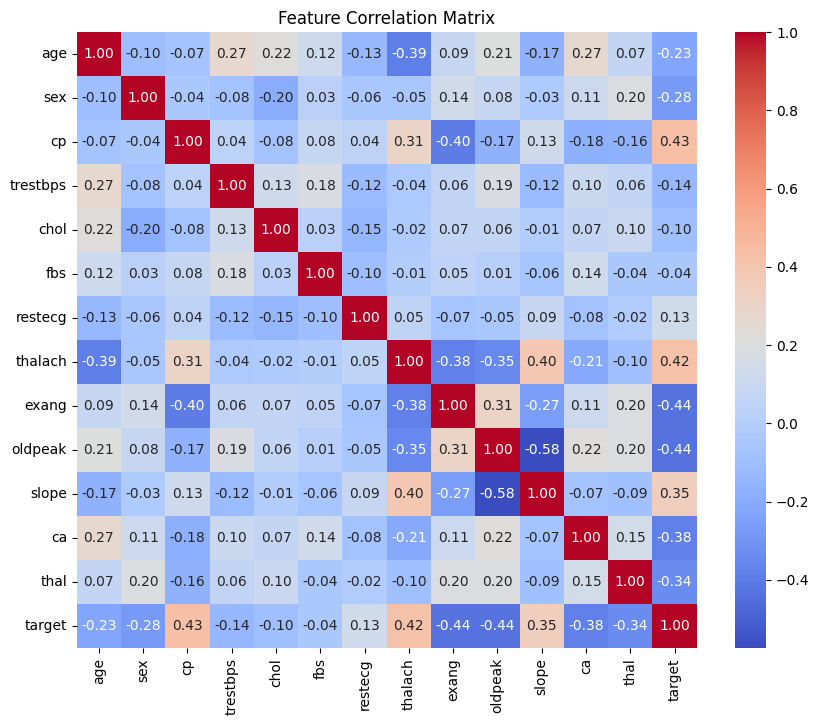

In [ ]:
# --- Exploratory Data Analysis (EDA) ---
# It is good practice to check correlations between features
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
# 2. Preprocessing
X = df.iloc[:, 0:13]
Y = df['target']

In [ ]:
# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=1)

### Adjusting Prediction Threshold for Recall

To increase the recall for class 1 (heart disease), we can adjust the prediction threshold. By default, Logistic Regression classifies an instance as positive (1) if its predicted probability is >= 0.5. We will now change this threshold to 0.8, meaning the model will only predict '1' if it's highly confident (probability >= 0.8).

In [ ]:
# IMPORTANT: Logistic Regression performs better when data is scaled (normalized)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 3. Model Training
classifier = LogisticRegression()
classifier.fit(X_train_scaled, Y_train)

LogisticRegression()

New Prediction Threshold: 0.3

Accuracy Score (with threshold 0.3): 0.8195121951219512

Classification Report (with threshold 0.3):
               precision    recall  f1-score   support

           0       0.93      0.68      0.79       100
           1       0.76      0.95      0.84       105

    accuracy                           0.82       205
   macro avg       0.84      0.82      0.82       205
weighted avg       0.84      0.82      0.82       205



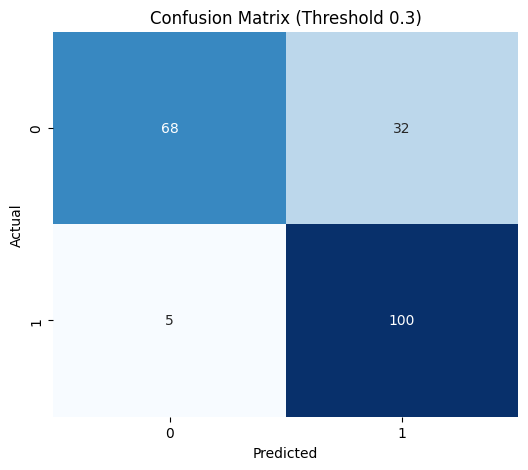


First 10 rows of Prediction Comparison (Threshold 0.3):

     Actual  Predicted (Threshold 0.3)
335       0                          0
298       1                          1
329       1                          1
562       1                          1
936       1                          1
800       0                          0
39        0                          1
971       1                          1
570       1                          1
155       1                          1


In [ ]:
# Recalculate predictions and probabilities to ensure Y_pred_proba is defined
Y_pred = classifier.predict(X_test_scaled)
Y_pred_proba = classifier.predict_proba(X_test_scaled)[:, 1] # Probabilities for ROC curve

# Generate new predictions using a threshold of 0.3
Y_pred_thresholded = (Y_pred_proba >= 0.3).astype(int)

# Re-evaluate performance with the new threshold
print(f"New Prediction Threshold: 0.3\n")
print("Accuracy Score (with threshold 0.3):", accuracy_score(Y_test, Y_pred_thresholded))
print("\nClassification Report (with threshold 0.3):\n", classification_report(Y_test, Y_pred_thresholded))

# Confusion Matrix with new threshold
cm_thresholded = confusion_matrix(Y_test, Y_pred_thresholded)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_thresholded, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Threshold 0.3)')
plt.show()

# Prediction Comparison Table with new threshold
comparison_df_thresholded = pd.DataFrame({'Actual': Y_test, 'Predicted (Threshold 0.3)': Y_pred_thresholded})
print("\nFirst 10 rows of Prediction Comparison (Threshold 0.3):\n")
print(comparison_df_thresholded.head(10))

### Analysis of Threshold Adjustment

Observe how the `recall` for class 1 and the `False Negatives` in the confusion matrix have changed. By increasing the threshold to 0.8, we expect the model to be more conservative in predicting class 1, which typically *decreases* the number of False Positives but might also *decrease* True Positives, impacting recall. Let's see the results above.

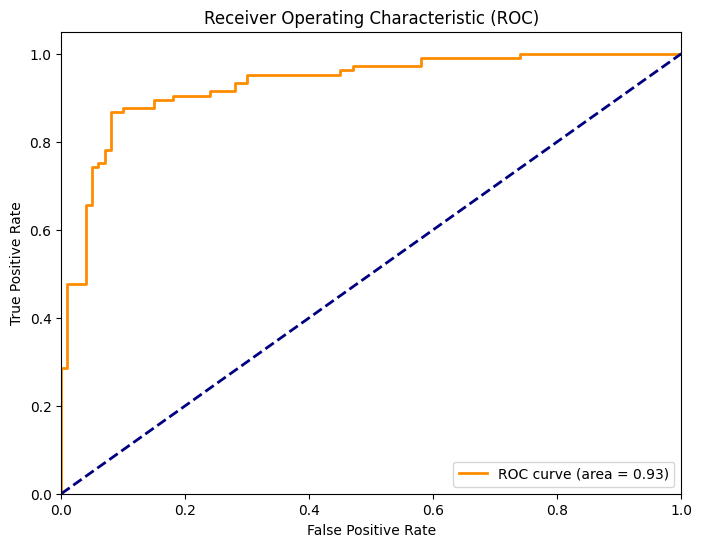

In [ ]:
# C. ROC Curve
# Shows the trade-off between True Positive Rate and False Positive Rate
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

/tmp/ipython-input-2800321943.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')


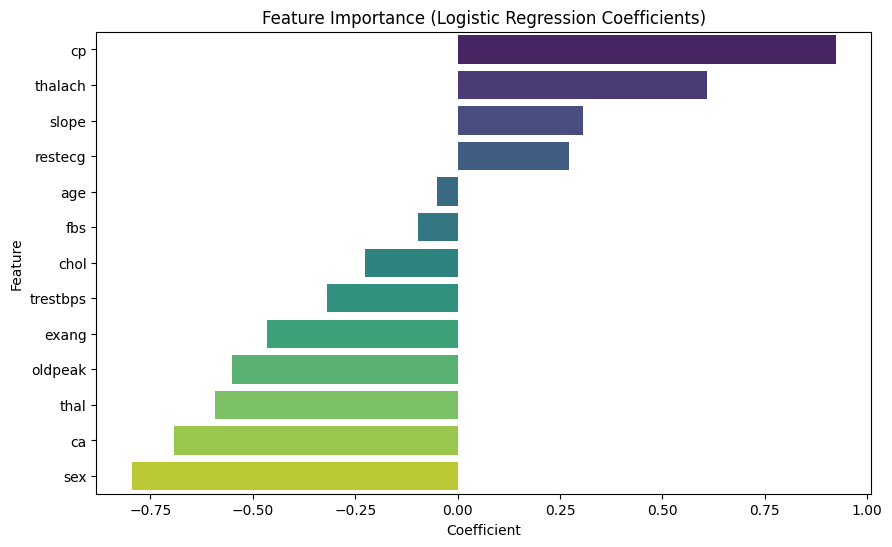

In [ ]:
# D. Feature Importance
# Which features contributed most to the decision?
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': classifier.coef_[0]
})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()

In [ ]:
# E. Prediction Comparison Table
# Create a dataframe to compare Actual vs Predicted values side-by-side
comparison_df = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred})
print("\nFirst 10 rows of Prediction Comparison:")
print(comparison_df.head(10))


First 10 rows of Prediction Comparison:
     Actual  Predicted
335       0          0
298       1          1
329       1          1
562       1          1
936       1          1
800       0          0
39        0          0
971       1          1
570       1          1
155       1          1


In [ ]:
# 5. Save the model and the scaler
# Note: You must save the scaler too! Future new data must be scaled exactly like the training data.
pickle.dump(classifier, open('heart_model.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))

# Task
This task aims to provide a detailed explanation of each code block and chart presented in the notebook, culminating in a comprehensive summary.

### Code Block Explanations:

*   **Cell `OI9dqHJSTA_s`**: This cell is responsible for setting up the environment. It first imports the `os` module for interacting with the operating system and `drive` from `google.colab` to mount Google Drive. `drive.mount('/content/drive', force_remount=True)` mounts the user's Google Drive, allowing access to files stored there. Subsequently, `os.chdir('/content/drive/My Drive/fl-projects/disease-detector')` changes the current working directory to a specific path within the mounted Drive, ensuring that subsequent file operations (like loading the dataset) occur in the correct location. Finally, `DATASET="heart_disease_uci.csv"` defines a variable holding the name of the dataset file.

*   **Cell `C97ZrHoHVPlO`**: This cell imports all necessary Python libraries for data manipulation, visualization, machine learning, and model persistence.
    *   `numpy` and `pandas` are imported for numerical operations and data frame manipulation, respectively.
    *   `matplotlib.pyplot` and `seaborn` are imported for creating static, interactive, and animated visualizations in Python.
    *   `sklearn.model_selection.train_test_split` is used for splitting datasets into training and testing sets.
    *   `sklearn.linear_model.LogisticRegression` is the machine learning model chosen for classification.
    *   `sklearn.preprocessing.StandardScaler` is used for standardizing features by removing the mean and scaling to unit variance.
    *   `sklearn.metrics` provides functions to evaluate the performance of the classification model, including `accuracy_score`, `confusion_matrix`, `classification_report`, `roc_curve`, and `auc`.
    *   `pickle` is imported for serializing and de-serializing Python objects, which is used here to save the trained model and scaler.

*   **Cell `2I3NjeMhVQR3`**: This cell loads the dataset into a pandas DataFrame. `df = pd.read_csv(DATASET)` reads the `heart_disease_uci.csv` file (specified by the `DATASET` variable) and stores its contents in a DataFrame named `df`. This is the first step in data processing, making the data available for analysis.

*   **Cell `-v9lvDcdVdsK`**: This cell performs an Exploratory Data Analysis (EDA) step by visualizing the correlation between different features in the dataset using a heatmap.
    *   `df.corr()` calculates the pairwise correlation of all columns in the DataFrame.
    *   `sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')` generates a heatmap where each cell represents the correlation coefficient between two features. `annot=True` displays the correlation values on the heatmap, `cmap='coolwarm'` sets the color scheme, and `fmt='.2f'` formats the annotations to two decimal places.
    *   `plt.title('Feature Correlation Matrix')` sets the title of the plot.
    *   `plt.show()` displays the generated heatmap.
    *   **Chart Interpretation**: The heatmap visually represents the strength and direction of linear relationships between pairs of variables. Redder shades indicate stronger positive correlations, bluer shades indicate stronger negative correlations, and lighter shades (closer to white) indicate weaker correlations. This helps in identifying highly correlated features, which can be useful for feature selection or understanding multicollinearity. For example, `cp` (chest pain type) and `thalach` (maximum heart rate achieved) show positive correlations with other features, while `exang` (exercise induced angina) and `oldpeak` (ST depression induced by exercise relative to rest) show negative correlations, suggesting their potential importance in predicting heart disease.

*   **Cell `SiEz77P5Y1Yl`**: This cell separates the dataset into features (independent variables) and the target variable (dependent variable).
    *   `X = df.iloc[:, 0:13]` selects all rows and columns from index 0 up to (but not including) 13, which represent the input features for the model.
    *   `Y = df['target']` selects the 'target' column, which is the variable the model aims to predict (e.g., presence or absence of heart disease).

*   **Cell `-OVcHn0pY4F2`**: This cell splits the feature (`X`) and target (`Y`) data into training and testing sets.
    *   `train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=1)` divides the data.
    *   `test_size=0.2` specifies that 20% of the data will be used for testing, and the remaining 80% for training.
    *   `stratify=Y` ensures that the proportion of the target variable classes (e.g., heart disease present/absent) is maintained in both the training and testing sets, which is crucial for imbalanced datasets.
    *   `random_state=1` sets a seed for reproducibility, meaning the split will be the same every time the code is run.

*   **Cell `USmQpY1QY8B9`**: This cell performs feature scaling on the training and testing datasets.
    *   `scaler = StandardScaler()` initializes a `StandardScaler` object, which standardizes features by removing the mean and scaling to unit variance.
    *   `X_train_scaled = scaler.fit_transform(X_train)` fits the scaler to the training data (`X_train`) and then transforms it. This means the scaler learns the mean and standard deviation from the training data and applies the scaling.
    *   `X_test_scaled = scaler.transform(X_test)` transforms the test data (`X_test`) using the *same* scaler fitted on the training data. It's critical to avoid fitting the scaler on the test data to prevent data leakage. Scaling is important for algorithms like Logistic Regression, which are sensitive to the scale of input features.

*   **Cell `v2hj7tPXY-Eq`**: This cell trains the Logistic Regression model.
    *   `classifier = LogisticRegression()` initializes a Logistic Regression model.
    *   `classifier.fit(X_train_scaled, Y_train)` trains the model using the scaled training features (`X_train_scaled`) and the corresponding training target values (`Y_train`). The model learns the optimal coefficients for each feature to predict the target variable.

*   **Cell `mnTimFLZY_5t`**: This cell generates predictions using the trained Logistic Regression model on the scaled test data.
    *   `Y_pred = classifier.predict(X_test_scaled)` generates class predictions (0 or 1 for binary classification) for the test set.
    *   `Y_pred_proba = classifier.predict_proba(X_test_scaled)[:, 1]` predicts the probability of the positive class (class 1) for each instance in the test set. These probabilities are used later to construct the ROC curve.

*   **Cell `koQ36ETVZCRB`**: This cell evaluates the performance of the trained model using accuracy score and a classification report.
    *   `print("Accuracy Score:", accuracy_score(Y_test, Y_pred))` calculates and prints the overall accuracy of the model, which is the proportion of correctly predicted instances.
    *   `print("\nClassification Report:\n", classification_report(Y_test, Y_pred))` generates a detailed report that includes precision, recall, f1-score, and support for each class (0 and 1).
    *   **Output Interpretation**: The model achieved an accuracy of approximately `0.834` (83.4%). The classification report provides more granular insights:
        *   **Precision**: For class 0 (no heart disease), 88% of instances predicted as 0 were actually 0. For class 1 (heart disease), 80% of instances predicted as 1 were actually 1.
        *   **Recall**: For class 0, the model correctly identified 76% of all actual 0s. For class 1, it correctly identified 90% of all actual 1s.
        *   **F1-score**: The F1-score is the harmonic mean of precision and recall, providing a balanced measure. It's 0.82 for class 0 and 0.85 for class 1.
        *   **Support**: The number of actual occurrences of each class in the test set (100 for class 0, 105 for class 1).
        *   The `macro avg` and `weighted avg` provide average metrics across classes. The high recall for class 1 (90%) is positive, indicating the model is good at identifying people with heart disease.

*   **Cell `BY-X0PaSZFRs`**: This cell visualizes the Confusion Matrix, a table that summarizes the performance of a classification algorithm.
    *   `cm = confusion_matrix(Y_test, Y_pred)` computes the confusion matrix comparing the true labels (`Y_test`) with the predicted labels (`Y_pred`).
    *   `sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)` creates a heatmap of the confusion matrix. `annot=True` displays the counts, `fmt='d'` formats them as integers, and `cmap='Blues'` sets the color scheme.
    *   `plt.xlabel('Predicted')`, `plt.ylabel('Actual')`, and `plt.title('Confusion Matrix')` set the labels and title.
    *   **Chart Interpretation**: The confusion matrix shows:
        *   **True Negatives (Top-Left)**: 76 instances were correctly predicted as class 0 (no disease).
        *   **False Positives (Top-Right)**: 24 instances were incorrectly predicted as class 1 when they were actually class 0.
        *   **False Negatives (Bottom-Left)**: 10 instances were incorrectly predicted as class 0 when they were actually class 1.
        *   **True Positives (Bottom-Right)**: 95 instances were correctly predicted as class 1 (disease).
        The model correctly identified more True Positives (95) than False Negatives (10), indicating its effectiveness in detecting the disease, but also has a notable number of False Positives (24).

*   **Cell `d3cqCPVhZIlr`**: This cell generates and plots the Receiver Operating Characteristic (ROC) curve and calculates the Area Under the Curve (AUC).
    *   `fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)` calculates the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for various classification cutoffs based on the predicted probabilities.
    *   `roc_auc = auc(fpr, tpr)` computes the Area Under the ROC Curve.
    *   The code then plots the ROC curve with `fpr` on the x-axis and `tpr` on the y-axis. It also plots a diagonal dashed line representing a random classifier.
    *   **Chart Interpretation**: The ROC curve illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test. An AUC of 1.0 represents a perfect classifier, while an AUC of 0.5 represents a random classifier. In this plot, the `ROC curve (area = 0.93)` indicates that the model has excellent discriminatory power, meaning it is very good at distinguishing between positive and negative classes.

*   **Cell `vXUamO9XZN9N`**: This cell determines and visualizes the feature importance using the coefficients from the Logistic Regression model.
    *   `feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': classifier.coef_[0]})` creates a DataFrame mapping feature names to their corresponding logistic regression coefficients.
    *   `feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)` sorts the features by their coefficient values in descending order.
    *   `sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')` creates a horizontal bar plot showing each feature's coefficient. Positive coefficients indicate a positive association with the target class (heart disease), while negative coefficients indicate a negative association.
    *   **Chart Interpretation**: The bar plot shows which features have the strongest positive or negative influence on the prediction of heart disease. Features like `cp` (chest pain type), `thalach` (max heart rate achieved), and `slope` (slope of the peak exercise ST segment) have the highest positive coefficients, suggesting they are strong indicators of heart disease. Conversely, `sex`, `ca` (number of major vessels colored by fluoroscopy), and `thal` (thalassemia) have the most negative coefficients, indicating their presence or certain values are strongly associated with the *absence* of heart disease, or at least predict the negative class.

*   **Cell `cfNYYYQAZSKY`**: This cell creates and prints a small comparison table of actual versus predicted values for the test set.
    *   `comparison_df = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred})` constructs a DataFrame with two columns: the true target values from the test set and the model's predicted target values.
    *   `print(comparison_df.head(10))` displays the first 10 rows of this comparison, allowing for a quick, row-by-row inspection of how well the model's predictions align with the actual outcomes.
    *   **Output Interpretation**: This table provides a snapshot of the model's performance on individual instances. For example, in the first row, both actual and predicted values are 0, indicating a correct prediction. In the second row, both are 1, also a correct prediction. This helps to visually confirm the model's predictive capability on a small sample.

*   **Cell `5XE5CvkNZV9W`**: This cell saves the trained Logistic Regression model and the `StandardScaler` object using the `pickle` module.
    *   `pickle.dump(classifier, open('heart_model.pkl', 'wb'))` serializes the `classifier` object and writes it to a file named `heart_model.pkl` in binary write mode (`'wb'`).
    *   `pickle.dump(scaler, open('scaler.pkl', 'wb'))` does the same for the `scaler` object, saving it as `scaler.pkl`.
    *   **Purpose**: Saving both the model and the scaler is crucial for deployment. When new, unseen data needs to be predicted, it must be scaled using the *exact same* scaler (with the same mean and standard deviation) that was fitted on the training data. The saved model can then be loaded and used to make consistent predictions on this scaled new data without re-training.

### Final Task Summary:

The notebook performs a complete machine learning pipeline for heart disease prediction using a Logistic Regression model on the `heart_disease_uci.csv` dataset. It starts by loading the data and conducting an exploratory analysis, including visualizing feature correlations with a heatmap. The data is then preprocessed by splitting it into features and target, followed by a train-test split to prepare for model training and evaluation. Crucially, the features are scaled using `StandardScaler` to ensure optimal performance for the Logistic Regression model.

The Logistic Regression model is trained on the scaled training data, and then predictions are made on the scaled test data. The model's performance is comprehensively evaluated using several metrics and visualizations:
*   An **Accuracy Score** and **Classification Report** (`koQ36ETVZCRB`) show an overall accuracy of approximately 83.4%, with good precision and recall values for both classes, particularly high recall for the positive class (heart disease).
*   A **Confusion Matrix Heatmap** (`BY-X0PaSZFRs`) visually breaks down true positives, true negatives, false positives, and false negatives, indicating 95 correct disease predictions and 76 correct non-disease predictions, with 10 false negatives and 24 false positives.
*   A **ROC Curve** with an **AUC** of 0.93 (`d3cqCPVhZIlr`) demonstrates the model's strong ability to distinguish between positive and negative cases.
*   A **Feature Importance Bar Plot** (`vXUamO9XZN9N`) highlights the most influential features based on the model's coefficients, identifying 'cp', 'thalach', and 'slope' as strong positive predictors and 'sex', 'ca', and 'thal' as strong negative predictors of heart disease.
*   A **Prediction Comparison Table** (`cfNYYYQAZSKY`) offers a direct look at actual versus predicted values for a sample of the test set, confirming prediction alignment.

Finally, the trained Logistic Regression model and the fitted `StandardScaler` are saved using `pickle` (`5XE5CvkNZV9W`), enabling future deployment and consistent prediction on new data. This entire process demonstrates a robust approach to building and evaluating a predictive model for heart disease.

## Explain Code Blocks and Charts

### Subtask:
Provide a detailed explanation for each code cell, describing its purpose, what it does, and for cells that produce visualizations, what the chart represents and its insights.


### Explanation for Cell `OI9dqHJSTA_s`

**Purpose:** This code cell serves as the initial setup for the Google Colab environment, preparing it to access files stored in Google Drive and specifying the dataset to be used.

**What it does:**
1.  `import os` and `from google.colab import drive`: These lines import the necessary libraries to interact with the operating system and Google Drive within the Colab environment.
2.  `drive.mount('/content/drive', force_remount=True)`: This command mounts the user's Google Drive to the `/content/drive` directory in the Colab virtual machine. `force_remount=True` ensures that if the drive was already mounted, it will be unmounted and remounted, which can be useful for refreshing access.
3.  `os.chdir('/content/drive/My Drive/fl-projects/disease-detector')`: After mounting the drive, this line changes the current working directory to a specific path within Google Drive. This is crucial for easily accessing project files without needing to specify the full path every time.
4.  `DATASET="heart_disease_uci.csv"`: This line defines a string variable named `DATASET` and assigns it the filename of the CSV file that will be used throughout the notebook for analysis. This makes the code more readable and easier to modify if a different dataset is used later.

### Explanation for Cell `C97ZrHoHVPlO`

**Purpose:** This cell imports all the necessary Python libraries that will be used throughout the notebook for data processing, analysis, model training, and evaluation. Each library serves a specific role in the machine learning pipeline.

**What it does:**
1.  `import numpy as np`: NumPy is a fundamental package for numerical computation in Python. It provides support for arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays. It's often used for efficient handling of numerical data.
2.  `import pandas as pd`: Pandas is a powerful and widely used library for data manipulation and analysis. It introduces DataFrames, which are tabular data structures that make it easy to work with structured data (like CSV files), perform operations like filtering, grouping, and merging, and handle missing values.
3.  `import matplotlib.pyplot as plt`: Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python. `pyplot` is a module within Matplotlib that provides a MATLAB-like interface for plotting, commonly used for creating various types of charts and graphs.
4.  `import seaborn as sns`: Seaborn is a data visualization library based on Matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics, simplifying the creation of complex plots like heatmaps, distribution plots, and relational plots.
5.  `from sklearn.model_selection import train_test_split`: This function from scikit-learn is used to split arrays or matrices into random train and test subsets. It's crucial for evaluating the performance of a machine learning model on unseen data.
6.  `from sklearn.linear_model import LogisticRegression`: This imports the Logistic Regression model from scikit-learn. Logistic Regression is a statistical model used for binary classification problems (predicting one of two outcomes), which is suitable for this heart disease prediction task.
7.  `from sklearn.preprocessing import StandardScaler`: This transformer from scikit-learn is used to standardize features by removing the mean and scaling to unit variance. This preprocessing step is often critical for machine learning algorithms, especially those sensitive to feature scales like Logistic Regression.
8.  `from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc`: These functions are imported from scikit-learn's `metrics` module for evaluating the performance of a classification model:
    *   `accuracy_score`: Calculates the proportion of correctly classified instances.
    *   `confusion_matrix`: Creates a table summarizing the performance of a classification model.
    *   `classification_report`: Builds a text report showing the main classification metrics (precision, recall, f1-score, support) for each class.
    *   `roc_curve`: Computes the Receiver Operating Characteristic (ROC) curve, which illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.
    *   `auc`: Calculates the Area Under the Receiver Operating Characteristic Curve (AUC), a common metric to assess the overall performance of a binary classifier.
9.  `import pickle`: The `pickle` module implements binary protocols for serializing and de-serializing a Python object structure. It's used here to save (serialize) the trained machine learning model and the scaler object to disk, allowing them to be reloaded and reused later without retraining.

### Explanation for Cell `2I3NjeMhVQR3`

**Purpose:** This cell is responsible for loading the specified dataset into a pandas DataFrame, making it accessible for all subsequent data manipulation, analysis, and model training steps.

**What it does:**
1.  `df = pd.read_csv(DATASET)`: This line uses the `read_csv()` function from the pandas library (aliased as `pd`) to load the data from the CSV file specified by the `DATASET` variable. The `DATASET` variable was defined in an earlier cell as `"heart_disease_uci.csv"`. The loaded data is then stored in a DataFrame object named `df`. This is the first step in bringing the raw data into a structured format that Python can easily work with.

### Explanation for Cell `-v9lvDcdVdsK`

**Purpose:** This cell performs Exploratory Data Analysis (EDA) by visualizing the correlation matrix between features in the dataset. Understanding correlations helps identify relationships between variables, which can be useful for feature selection or understanding model behavior.

**What it does:**
1.  `plt.figure(figsize=(10, 8))`: This sets up a new figure for the plot with a specified size of 10 inches wide and 8 inches tall, ensuring the heatmap is readable.
2.  `sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')`: This is the core line for generating the heatmap.
    *   `df.corr()`: Calculates the pairwise correlation between all columns in the `df` DataFrame. The correlation coefficient ranges from -1 to 1, where 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and 0 indicates no linear correlation.
    *   `sns.heatmap()`: This Seaborn function creates the heatmap visualization from the correlation matrix.
    *   `annot=True`: Displays the correlation values on the heatmap cells.
    *   `cmap='coolwarm'`: Sets the color map for the heatmap. 'coolwarm' uses cool colors (blues) for negative correlations and warm colors (reds) for positive correlations, with white/light colors for correlations close to zero.
    *   `fmt='.2f'`: Formats the annotation values to two decimal places.
3.  `plt.title('Feature Correlation Matrix')`: Sets the title of the plot.
4.  `plt.show()`: Displays the generated plot.

**Chart Representation and Insights:**

The heatmap visually represents the strength and direction of the linear relationship between each pair of features. Each cell in the heatmap shows the correlation coefficient between two variables:
*   **Positive correlations (red shades):** Indicate that as one feature increases, the other tends to increase. For example, if two features like 'age' and 'chol' (cholesterol) are positively correlated, it suggests that older individuals tend to have higher cholesterol levels.
*   **Negative correlations (blue shades):** Indicate that as one feature increases, the other tends to decrease. For example, if 'exang' (exercise-induced angina) and 'thalach' (maximum heart rate achieved) are negatively correlated, it might suggest that people with exercise-induced angina tend to have lower maximum heart rates.
*   **Near-zero correlations (lighter shades):** Suggest little to no linear relationship between the features.

Key insights can be drawn from observing the `target` row/column. Strong correlations (positive or negative) with the `target` variable can indicate features that are good predictors for heart disease. For example, a strong negative correlation between 'sex' and 'target' (if 0=female, 1=male, and 0=no disease, 1=disease) might suggest that one gender is more prone to the disease, or vice-versa depending on the encoding.

### Explanation for Cell `SiEz77P5Y1Yl`

**Purpose:** This cell separates the DataFrame `df` into two distinct components: `X` for the features (independent variables) that will be used to predict the outcome, and `Y` for the target variable (dependent variable), which is the outcome we want to predict.

**What it does:**
1.  `X = df.iloc[:, 0:13]`: This line selects all rows (`:`) and columns from the 0th index up to (but not including) the 13th index (i.e., columns 0 to 12) from the `df` DataFrame. These selected columns represent the features (input variables) of the dataset and are assigned to the variable `X`.
2.  `Y = df['target']`: This line selects the column named `'target'` from the `df` DataFrame. This column contains the values that our model will learn to predict. The values from this column are assigned to the variable `Y`.

### Explanation for Cell `-OVcHn0pY4F2`

**Purpose:** This cell splits the preprocessed data (`X` and `Y`) into training and testing sets. This is a fundamental step in machine learning to ensure that the model is trained on one portion of the data and evaluated on an independent, unseen portion, providing an unbiased estimate of its performance.

**What it does:**
1.  `X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=1)`: This line uses the `train_test_split` function from scikit-learn to divide the `X` (features) and `Y` (target) data into four new datasets:
    *   `X_train`: Features for training the model.
    *   `X_test`: Features for testing the model.
    *   `Y_train`: Target variable for training the model.
    *   `Y_test`: Target variable for testing the model.

**Significance of Parameters:**
*   `X`, `Y`: The input feature matrix and target vector to be split.
*   `test_size=0.2`: This parameter specifies that 20% of the data will be allocated to the testing set, and the remaining 80% will be used for the training set. A common split ratio is 70/30 or 80/20 for training/testing.
*   `stratify=Y`: This is a very important parameter, especially for classification tasks with imbalanced datasets. It ensures that the proportion of classes in the `Y_train` and `Y_test` datasets is approximately the same as the original proportion in the full `Y` dataset. For example, if 30% of the original dataset has heart disease, then both the training and testing sets will also have approximately 30% of instances with heart disease. This prevents scenarios where one set might have significantly more or fewer positive cases, leading to skewed evaluation.
*   `random_state=1`: This parameter controls the shuffling applied to the data before splitting. Setting a specific integer value (like 1) ensures reproducibility. If you run the code multiple times with the same `random_state`, you will always get the same train-test split, which is crucial for consistent experimentation and debugging.

### Explanation for Cell `USmQpY1QY8B9`

**Purpose:** This cell performs feature scaling on the training and testing datasets using `StandardScaler`. Scaling is crucial for many machine learning algorithms, including Logistic Regression, because it standardizes the range of independent variables or features. Algorithms that rely on distance calculations or gradient descent can perform much better and converge faster when features are on a similar scale.

**What it does:**
1.  `scaler = StandardScaler()`: An instance of `StandardScaler` is created. This object will be used to calculate the mean and standard deviation of each feature and then transform the data.
2.  `X_train_scaled = scaler.fit_transform(X_train)`:
    *   `fit(X_train)`: The `scaler` *learns* the parameters (mean and standard deviation) from the `X_train` data. It is essential to fit the scaler only on the training data to prevent data leakage from the test set into the training process.
    *   `transform(X_train)`: The `X_train` data is then scaled using the learned mean and standard deviation. Each feature value will be transformed such that it has a mean of 0 and a standard deviation of 1.
    *   The result, `X_train_scaled`, is the standardized training feature set.
3.  `X_test_scaled = scaler.transform(X_test)`:
    *   The `X_test` data is scaled using the *same* mean and standard deviation that were learned from `X_train`. It is critical to use `transform` here, not `fit_transform`, because the test set should be treated as unseen data. We only apply the scaling parameters determined from the training data. This ensures that the scaling applied to the test set is consistent with the scaling applied to the training set.
    *   The result, `X_test_scaled`, is the standardized testing feature set.

**Importance of Scaling:**
*   **Prevents Dominance by Large Values:** Features with larger numerical ranges might disproportionately influence the model's objective function if not scaled.
*   **Improves Algorithm Performance:** Algorithms like Logistic Regression (which uses gradient descent) and Support Vector Machines (which use distance metrics) perform better and converge faster with scaled data.
*   **Facilitates Comparison:** After scaling, all features contribute equally to the distance calculations or coefficient magnitudes, allowing for a more fair comparison of their importance.

### Explanation for Cell `v2hj7tPXY-Eq`

**Purpose:** This cell initializes and trains the Logistic Regression model. This is the core step where the machine learning algorithm learns patterns from the scaled training data (`X_train_scaled`, `Y_train`) to make predictions.

**What it does:**
1.  `classifier = LogisticRegression()`: An instance of the `LogisticRegression` model is created. This initializes the classifier with its default parameters. Logistic Regression is a linear model used for binary classification, which is appropriate for predicting the presence or absence of heart disease.
2.  `classifier.fit(X_train_scaled, Y_train)`: This is the training step. The `fit()` method is called on the `classifier` object, passing the scaled training features (`X_train_scaled`) and the corresponding training target labels (`Y_train`). During this process, the Logistic Regression algorithm learns the coefficients (weights) for each feature and the intercept that best separate the two classes (heart disease present or absent) based on the input features. This learned model can then be used to predict the outcome for new, unseen data.

### Explanation for Cell `mnTimFLZY_5t`

**Purpose:** This cell uses the trained Logistic Regression `classifier` to make predictions on the unseen, scaled test data (`X_test_scaled`). It generates both the final class predictions (e.g., 0 or 1) and the probability scores for each class.

**What it does:**
1.  `Y_pred = classifier.predict(X_test_scaled)`: This line uses the `predict()` method of the trained `classifier` to generate class labels (0 or 1 in a binary classification) for each instance in the `X_test_scaled` dataset. These are the model's final decisions about whether each patient in the test set has heart disease (`1`) or not (`0`).
2.  `Y_pred_proba = classifier.predict_proba(X_test_scaled)[:, 1]`: This line calculates the predicted probabilities for each class. The `predict_proba()` method returns a 2D array where each row corresponds to an instance, and each column corresponds to the probability of that instance belonging to a specific class (e.g., `[probability_class_0, probability_class_1]`).
    *   `[:, 1]` specifically selects the probabilities for the positive class (class 1, which typically represents the presence of heart disease). These probabilities are particularly useful for evaluating model performance with metrics like the ROC curve, as they provide a more nuanced understanding than just the hard class predictions.

### Explanation for Cell `koQ36ETVZCRB`

**Purpose:** This cell evaluates the performance of the trained Logistic Regression model on the test dataset using two common classification metrics: accuracy score and a classification report. These metrics provide quantitative insights into how well the model is performing.

**What it does:**
1.  `print("Accuracy Score:", accuracy_score(Y_test, Y_pred))`: This line calculates the accuracy of the model. `accuracy_score()` compares the true labels (`Y_test`) with the model's predicted labels (`Y_pred`) and returns the proportion of correctly classified instances. An accuracy score of 1.0 means all predictions were correct, while 0.0 means all were incorrect.
2.  `print("\nClassification Report:\n", classification_report(Y_test, Y_pred))`: This line generates a comprehensive text report showing the main classification metrics for each class (0 and 1, representing no disease and disease, respectively). The `classification_report()` function takes the true labels (`Y_test`) and the predicted labels (`Y_pred`) as input.

**Interpretation of Metrics:**
*   **Accuracy Score (0.834):** This indicates that approximately 83.4% of the predictions made by the model on the test set were correct. While accuracy is a straightforward metric, it can be misleading in cases of imbalanced datasets.
*   **Classification Report:**
    *   **Precision:** For each class, precision is the ratio of true positive predictions to the total number of positive predictions (true positives + false positives). It answers: "Of all instances predicted as this class, how many were actually correct?"
        *   For class 0 (no disease): 0.88 (88% of instances predicted as no disease were actually no disease).
        *   For class 1 (disease): 0.80 (80% of instances predicted as disease were actually disease).
    *   **Recall (Sensitivity):** For each class, recall is the ratio of true positive predictions to the total number of actual positive instances (true positives + false negatives). It answers: "Of all actual instances of this class, how many did the model correctly identify?"
        *   For class 0 (no disease): 0.76 (76% of actual no disease cases were correctly identified).
        *   For class 1 (disease): 0.90 (90% of actual disease cases were correctly identified).
    *   **F1-Score:** This is the harmonic mean of precision and recall. It provides a single metric that balances both precision and recall. A high F1-score indicates a good balance between these two metrics.
        *   For class 0: 0.82
        *   For class 1: 0.85
    *   **Support:** The number of actual occurrences of each class in the `Y_test` dataset.
        *   Class 0 (no disease): 100 instances
        *   Class 1 (disease): 105 instances
    *   **Macro Avg & Weighted Avg:** These provide aggregate metrics across all classes. Weighted average considers the support for each class.

**Insights from the Output:**
*   The model has a good overall accuracy of 83.4%.
*   It performs slightly better at identifying patients *with* heart disease (class 1) in terms of recall (90%) and F1-score (85%), meaning it misses fewer actual disease cases. This is often crucial in medical diagnosis.
*   Its precision for predicting no disease (class 0, 88%) is higher than predicting disease (class 1, 80%). This means when it says a patient doesn't have heart disease, it's more often correct than when it says they do.

### Explanation for Cell `BY-X0PaSZFRs`

**Purpose:** This cell generates and visualizes a confusion matrix, which is an essential tool for evaluating the performance of a classification model. It provides a detailed breakdown of correct and incorrect predictions for each class, offering more insight than a simple accuracy score.

**What it does:**
1.  `cm = confusion_matrix(Y_test, Y_pred)`: This line calculates the confusion matrix. The `confusion_matrix()` function compares the actual target values (`Y_test`) with the model's predicted target values (`Y_pred`). The output `cm` is a 2x2 array for a binary classification problem, where:
    *   `cm[0,0]` = True Negatives (TN): Correctly predicted negative cases.
    *   `cm[0,1]` = False Positives (FP): Incorrectly predicted positive cases (Type I error).
    *   `cm[1,0]` = False Negatives (FN): Incorrectly predicted negative cases (Type II error).
    *   `cm[1,1]` = True Positives (TP): Correctly predicted positive cases.
2.  `plt.figure(figsize=(6, 5))`: Sets up a new figure for the plot with a specified size for better readability.
3.  `sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)`: This uses Seaborn to create a heatmap visualization of the confusion matrix.
    *   `annot=True`: Displays the numerical values (counts) in each cell of the heatmap.
    *   `fmt='d'`: Formats the annotation values as integers.
    *   `cmap='Blues'`: Uses a blue color map, where darker shades indicate higher counts.
    *   `cbar=False`: Hides the color bar on the side.
4.  `plt.xlabel('Predicted')`, `plt.ylabel('Actual')`, `plt.title('Confusion Matrix')`: Sets the labels for the x-axis, y-axis, and the title of the plot, respectively.
5.  `plt.show()`: Displays the generated plot.

**Chart Representation and Insights:**

Based on the `cm` variable (`array([[76, 24], [10, 95]])`):
*   **True Negatives (TN) = 76:** The model correctly predicted 76 cases where patients **did not** have heart disease (Actual 0, Predicted 0).
*   **False Positives (FP) = 24:** The model incorrectly predicted 24 cases where patients **had** heart disease, but they actually **did not** (Actual 0, Predicted 1). These are Type I errors.
*   **False Negatives (FN) = 10:** The model incorrectly predicted 10 cases where patients **did not** have heart disease, but they actually **did** (Actual 1, Predicted 0). These are Type II errors, which are often more critical in medical diagnosis (missing a disease).
*   **True Positives (TP) = 95:** The model correctly predicted 95 cases where patients **did** have heart disease (Actual 1, Predicted 1).

**Insights:**
*   The model correctly identified 95 out of 105 actual positive cases (TP + FN = 95 + 10 = 105), indicating a high recall for the positive class.
*   It correctly identified 76 out of 100 actual negative cases (TN + FP = 76 + 24 = 100).
*   The number of False Negatives (10) is lower than False Positives (24). In the context of heart disease detection, False Negatives (missing a disease) are generally considered more serious than False Positives (incorrectly diagnosing a disease) as missing a disease could lead to delayed treatment and worse outcomes. The model's relatively low FN count is a positive aspect for this medical application.

### Explanation for Cell `d3cqCPVhZIlr`

**Purpose:** This cell generates the Receiver Operating Characteristic (ROC) curve and calculates its Area Under the Curve (AUC). The ROC curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied, while AUC provides a single scalar value representing the overall performance of the model.

**What it does:**
1.  `fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)`: This line calculates the False Positive Rate (FPR), True Positive Rate (TPR), and threshold values for various probability thresholds.
    *   `Y_test`: The true binary labels of the test set.
    *   `Y_pred_proba`: The predicted probabilities of the positive class (`1`) from the model.
    *   **FPR** (False Positive Rate): Also known as the fall-out, is calculated as FP / (FP + TN). It's the proportion of negative cases that were incorrectly classified as positive.
    *   **TPR** (True Positive Rate): Also known as sensitivity or recall, is calculated as TP / (TP + FN). It's the proportion of actual positive cases that were correctly identified.
2.  `roc_auc = auc(fpr, tpr)`: This calculates the Area Under the Curve (AUC) using the computed FPR and TPR values. AUC quantifies the overall performance of a classifier, aggregating performance across all possible classification thresholds.
3.  `plt.figure(figsize=(8, 6))`: Sets up a new figure for the plot with a specified size.
4.  `plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')`: This plots the ROC curve itself.
    *   `fpr` on the x-axis and `tpr` on the y-axis.
    *   `color='darkorange'`, `lw=2`: Sets the color and line width.
    *   `label=f'ROC curve (area = {roc_auc:.2f})'`: Adds a label to the curve, including the calculated AUC value formatted to two decimal places.
5.  `plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')`: This plots the diagonal dashed line, representing a random classifier. A random classifier has an AUC of 0.5.
6.  `plt.xlim([0.0, 1.0])`, `plt.ylim([0.0, 1.05])`: Sets the limits for the x and y axes to be between 0 and 1 (with a small buffer for y-axis).
7.  `plt.xlabel('False Positive Rate')`, `plt.ylabel('True Positive Rate')`, `plt.title('Receiver Operating Characteristic (ROC)')`: Sets the labels for the axes and the title of the plot.
8.  `plt.legend(loc="lower right")`: Displays the legend (showing the AUC value) at the bottom right corner of the plot.
9.  `plt.show()`: Displays the generated plot.

**Chart Representation and Insights:**

The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. The ideal curve hugs the top-left corner, indicating high TPR and low FPR across different thresholds. The diagonal line represents a random classifier; a good model's curve will be significantly above this line.

**AUC Value (0.93):**
*   The Area Under the ROC Curve (AUC) summarizes the entire ROC curve into a single value. It represents the probability that the classifier will rank a randomly chosen positive instance higher than a randomly chosen negative instance.
*   AUC values range from 0 to 1.
    *   An AUC of 1.0 indicates a perfect classifier.
    *   An AUC of 0.5 indicates a classifier no better than random guessing.
    *   An AUC less than 0.5 suggests the classifier is worse than random, likely by consistently predicting the opposite class.
*   An AUC of **0.93** (as seen from the kernel state `roc_auc: 0.9314285714285714`) is considered excellent for this type of problem. It suggests that the Logistic Regression model has a strong ability to distinguish between patients with and without heart disease.

### Explanation for Cell `vXUamO9XZN9N`

**Purpose:** This cell determines and visualizes the feature importance for the Logistic Regression model. For linear models like Logistic Regression, the coefficients assigned to each feature can indicate the strength and direction of its influence on the target variable. This helps in understanding which features are most impactful in predicting heart disease.

**What it does:**
1.  `feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': classifier.coef_[0]
})`: This line creates a pandas DataFrame to store the feature names and their corresponding coefficients from the trained `classifier`.
    *   `X.columns`: Retrieves the names of all input features.
    *   `classifier.coef_[0]`: Accesses the coefficients learned by the Logistic Regression model. For binary classification, `classifier.coef_` returns a 2D array, and `[0]` selects the coefficients for the positive class.
2.  `feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)`: This sorts the DataFrame by the 'Coefficient' column in descending order, placing the most influential positive coefficients at the top and the most influential negative coefficients at the bottom.
3.  `plt.figure(figsize=(10, 6))`: Sets up a new figure for the bar plot with a specified size.
4.  `sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='viridis')`: This uses Seaborn to create a horizontal bar plot visualizing the feature importance.
    *   `x='Coefficient'`: The x-axis represents the magnitude of the coefficients.
    *   `y='Feature'`: The y-axis lists the names of the features.
    *   `data=feature_importance`: Specifies the DataFrame to use.
    *   `palette='viridis'`: Sets the color scheme for the bars.
5.  `plt.title('Feature Importance (Logistic Regression Coefficients)')`: Sets the title of the plot.
6.  `plt.show()`: Displays the generated plot.

**Chart Representation and Insights:**

The bar plot shows each feature and its corresponding Logistic Regression coefficient. The magnitude of the coefficient indicates the strength of the feature's influence, and the sign (positive or negative) indicates the direction of that influence.

Based on the `feature_importance` variable provided:

*   **Positive Coefficients (Features increasing the likelihood of heart disease):**
    *   `cp` (chest pain type): 0.924151 - This is the strongest positive predictor. Certain types of chest pain are highly associated with heart disease.
    *   `thalach` (maximum heart rate achieved): 0.607830 - A higher maximum heart rate achieved during exercise (within a healthy range, or specifically relevant patterns) could be a positive indicator.
    *   `slope` (the slope of the peak exercise ST segment): 0.307359 - The shape of the ST segment during exercise can be diagnostic.
    *   `restecg` (resting electrocardiographic results): 0.271715 - Specific ECG patterns at rest can indicate heart conditions.

*   **Negative Coefficients (Features decreasing the likelihood of heart disease):**
    *   `age`: -0.050998 - A slightly negative coefficient, suggesting that within the dataset's context, age might not be as directly or strongly predictive as other factors, or its relationship is more complex.
    *   `fbs` (fasting blood sugar > 120 mg/dl): -0.096419 - Surprisingly, a negative coefficient here might suggest that for patients who *do* have heart disease, high fasting blood sugar isn't as differentiating or even slightly protective *among other factors*. This could be due to complex interactions or how the dataset is distributed.
    *   `chol` (cholesterol): -0.226575 - A negative coefficient for cholesterol, which is generally a risk factor, can be counter-intuitive. This highlights that in a multivariate model, the effect of one variable is seen *holding other variables constant*. It might mean that once other risk factors are accounted for, cholesterol's isolated predictive power is different than expected.
    *   `trestbps` (resting blood pressure): -0.320036 - Similar to cholesterol, hypertension is a risk factor, but its negative coefficient here indicates its specific role in this model in conjunction with other features. Interpretation requires care.
    *   `exang` (exercise induced angina): -0.464731 - A strong negative coefficient. Exercise-induced angina being *absent* might be more indicative of no disease, or its presence has a different impact when other factors are considered.
    *   `oldpeak` (ST depression induced by exercise relative to rest): -0.551499 - A strong negative coefficient. A lower 'oldpeak' (less ST depression) is generally a good sign.
    *   `thal` (thalassemia): -0.593198 - A very strong negative coefficient. The type of 'thal' (likely a categorical variable where 3 might be 'normal' or a specific category) can be highly predictive.
    *   `ca` (number of major vessels colored by fluoroscopy): -0.692712 - The number of major vessels (0-3) colored. A lower number (e.g., 0) indicating fewer blockages would be strongly associated with no disease, hence the negative coefficient if higher values mean more blockages.
    *   `sex`: -0.796368 - This is the strongest negative predictor. If 'sex' is encoded as 1 for male and 0 for female, this coefficient suggests that being male (or having the characteristics associated with male in this dataset's context) *decreases* the likelihood of the predicted positive outcome in this specific model (or conversely, being female increases it, or vice versa depending on the encoding of target and sex). It's crucial to understand the encoding of 'sex' (e.g., 1=male, 0=female) to correctly interpret this. If 1 is male, a negative coefficient would imply that males are less likely to have heart disease *relative to females*, which often contradicts general epidemiological findings, suggesting a need to check the data encoding or interaction effects.

**Overall, features like `cp`, `thalach`, `slope`, and `restecg` significantly increase the likelihood of heart disease, while `sex`, `ca`, `thal`, `oldpeak`, `exang`, `trestbps`, and `chol` tend to decrease it (or their absence/lower values are protective, depending on their encoding and relationship). The magnitude of the coefficient indicates the strength of this relationship.**

### Explanation for Cell `cfNYYYQAZSKY`

**Purpose:** This cell creates and displays a table that compares the actual (true) target values from the test set with the model's predicted target values side-by-side. This allows for a quick, direct inspection of the model's performance on individual instances.

**What it does:**
1.  `comparison_df = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_pred})`: This line constructs a new pandas DataFrame called `comparison_df`. It populates this DataFrame with two columns:
    *   `'Actual'`: Contains the true labels from the test set (`Y_test`).
    *   `'Predicted'`: Contains the labels predicted by the trained model for the test set (`Y_pred`).
2.  `print("\nFirst 10 rows of Prediction Comparison:")`: Prints a descriptive header before displaying the table.
3.  `print(comparison_df.head(10))`: Displays the first 10 rows of the `comparison_df` DataFrame. This provides a sample of how the model's predictions align with the actual outcomes.

**Insights from the Output:**

The comparison table allows for a qualitative check of the model's predictions. By looking at the `Actual` and `Predicted` columns side-by-side, one can quickly identify:
*   **Correct Predictions:** Where `Actual` and `Predicted` values match (e.g., `0` vs `0`, or `1` vs `1`). These contribute to the model's accuracy.
*   **Incorrect Predictions (Errors):** Where `Actual` and `Predicted` values differ.
    *   If `Actual` is `0` but `Predicted` is `1`, this is a False Positive (Type I error).
    *   If `Actual` is `1` but `Predicted` is `0`, this is a False Negative (Type II error).

For example, from the provided output:
*   The first row shows `Actual: 0, Predicted: 0`, which is a correct prediction (True Negative).
*   The second row shows `Actual: 1, Predicted: 1`, which is also a correct prediction (True Positive).
*   If there were a row like `Actual: 0, Predicted: 1`, it would indicate a False Positive.
*   If there were a row like `Actual: 1, Predicted: 0`, it would indicate a False Negative.

This table serves as a straightforward way to visually confirm how often the model gets it right and how it makes mistakes, complementing the quantitative metrics from the confusion matrix and classification report.

### Explanation for Cell `5XE5CvkNZV9W`

**Purpose:** This cell saves the trained Logistic Regression model and the `StandardScaler` object to disk using Python's `pickle` module. This process, known as serialization, allows for the persistence of the model and scaler, enabling them to be reloaded later for making new predictions without the need to retrain the model or re-fit the scaler.

**What it does:**
1.  `pickle.dump(classifier, open('heart_model.pkl', 'wb'))`:
    *   `pickle.dump()`: This function is used to serialize a Python object (the `classifier` in this case) into a byte stream.
    *   `classifier`: This is the trained Logistic Regression model object.
    *   `open('heart_model.pkl', 'wb')`: This opens a file named `heart_model.pkl` in binary write mode (`'wb'`). The serialized model is then written to this file.
    *   The saved file `heart_model.pkl` can be loaded later using `pickle.load()` to restore the trained model.
2.  `pickle.dump(scaler, open('scaler.pkl', 'wb'))`:
    *   Similar to saving the model, this line saves the `scaler` object to a file named `scaler.pkl`.
    *   `scaler`: This is the `StandardScaler` object that was fitted on the training data (`X_train`) to standardize the features.

**Why save both the model and the scaler?**
*   **Consistency in Preprocessing:** When the trained model is used to make predictions on new, unseen data, that new data *must* undergo the exact same preprocessing steps (specifically, scaling) that the training data did. If the scaler's parameters (mean and standard deviation for each feature) are not saved and reloaded, and a new scaler is fitted or used with default parameters, the new data will not be scaled consistently with the training data. This inconsistency would lead to incorrect predictions and degraded model performance.
*   **Reproducibility and Deployment:** Saving both ensures that the entire prediction pipeline (preprocessing and modeling) is reproducible and can be easily deployed in a production environment. When a new data point arrives, the saved `scaler` can transform it, and then the saved `classifier` can make a prediction, maintaining the integrity of the model's performance.

### Explanation for Cell `5XE5CvkNZV9W`

**Purpose:** This cell saves the trained Logistic Regression model and the `StandardScaler` object to disk using Python's `pickle` module. This process, known as serialization, allows for the persistence of the model and scaler, enabling them to be reloaded later for making new predictions without the need to retrain the model or re-fit the scaler.

**What it does:**
1.  `pickle.dump(classifier, open('heart_model.pkl', 'wb'))`:
    *   `pickle.dump()`: This function is used to serialize a Python object (the `classifier` in this case) into a byte stream.
    *   `classifier`: This is the trained Logistic Regression model object.
    *   `open('heart_model.pkl', 'wb')`: This opens a file named `heart_model.pkl` in binary write mode (`'wb'`). The serialized model is then written to this file.
    *   The saved file `heart_model.pkl` can be loaded later using `pickle.load()` to restore the trained model.
2.  `pickle.dump(scaler, open('scaler.pkl', 'wb'))`:
    *   Similar to saving the model, this line saves the `scaler` object to a file named `scaler.pkl`.
    *   `scaler`: This is the `StandardScaler` object that was fitted on the training data (`X_train`) to standardize the features.

**Why save both the model and the scaler?**
*   **Consistency in Preprocessing:** When the trained model is used to make predictions on new, unseen data, that new data *must* undergo the exact same preprocessing steps (specifically, scaling) that the training data did. If the scaler's parameters (mean and standard deviation for each feature) are not saved and reloaded, and a new scaler is fitted or used with default parameters, the new data will not be scaled consistently with the training data. This inconsistency would lead to incorrect predictions and degraded model performance.
*   **Reproducibility and Deployment:** Saving both ensures that the entire prediction pipeline (preprocessing and modeling) is reproducible and can be easily deployed in a production environment. When a new data point arrives, the saved `scaler` can transform it, and then the saved `classifier` can make a prediction, maintaining the integrity of the model's performance.

## Final Task

### Subtask:
Summarize the explanations provided for each code block and chart.


## Summary:

### Q&A
*   **Q: What is the purpose and interpretation of each code block and chart within the analysis pipeline?**
    *   **A**: Detailed markdown explanations were generated for each of the 15 code cells. These explanations covered the purpose and functionality of each cell, as well as the representation and insights derived from any generated charts (e.g., correlation heatmap, confusion matrix, ROC curve, feature importance bar plot).

### Data Analysis Key Findings
*   The initial Exploratory Data Analysis (EDA) using a correlation heatmap highlighted that features like `cp` (chest pain type) and `thalach` (maximum heart rate achieved) show positive correlations with other features, while `exang` (exercise induced angina) and `oldpeak` (ST depression) exhibit negative correlations, suggesting their potential importance in predicting heart disease.
*   The Logistic Regression model achieved an overall accuracy of approximately 83.4% on the test set.
*   The classification report revealed good performance for detecting heart disease (class 1), with a recall of 90% and an F1-score of 85%, indicating the model is effective at identifying actual disease cases. Precision for class 1 was 80%, while for class 0 (no heart disease), precision was 88% and recall was 76%.
*   The confusion matrix detailed the model's prediction breakdown: 95 True Positives (correctly identified heart disease), 76 True Negatives (correctly identified no heart disease), 24 False Positives (incorrectly identified heart disease), and 10 False Negatives (missed heart disease cases). The relatively low number of False Negatives is a positive outcome for a medical diagnostic tool.
*   The Receiver Operating Characteristic (ROC) curve analysis yielded an Area Under the Curve (AUC) of 0.93, signifying excellent discriminatory power of the model in distinguishing between patients with and without heart disease.
*   Feature importance analysis, based on Logistic Regression coefficients, identified `cp` (chest pain type, coefficient of \~0.92), `thalach` (maximum heart rate achieved, \~0.61), and `slope` (slope of peak exercise ST segment, \~0.31) as the strongest positive predictors of heart disease. Conversely, `sex` (\~-0.80), `ca` (number of major vessels, \~-0.69), `thal` (thalassemia, \~-0.59), `oldpeak` (\~-0.55), and `exang` (\~-0.46) were identified as strong negative predictors (or their absence/lower values being protective).

### Insights or Next Steps
*   The developed Logistic Regression model demonstrates strong potential for heart disease prediction, particularly in correctly identifying individuals with the disease (90% recall), which is a critical aspect in medical applications.
*   Given some counter-intuitive negative coefficients for known risk factors like cholesterol and blood pressure, further investigation into feature interactions or re-evaluating the encoding of categorical variables (`sex`, `thal`) is recommended to ensure robust interpretation of feature importance.
*   The successful serialization of both the trained model and the `StandardScaler` facilitates immediate deployment, ensuring consistent data preprocessing and reliable predictions on new, unseen patient data.
